In [3]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Predictive Maintenance

In this notebook, we will show how to obtain the final plot from the blog post by a series of data manipulation steps.

### Load Data

In [4]:
# load the processed data in CSV format
train_df = pd.read_csv('../data/processed/train.csv')
test_df = pd.read_csv('../data/processed/test.csv')
rul_df = pd.read_csv('../data/processed/RUL.csv')

# for convenience, identify the sensor and operational setting columns
sensor_columns = [col for col in train_df.columns if col.startswith("sensor")]
setting_columns = [col for col in train_df.columns if col.startswith("setting")] 

### Data Description
The `test.csv` and `train.csv` files are in the following format:

| Column     | Description                                                      |
|------------|------------------------------------------------------------------|
| dataset_id | id of the original dataset of this instance                      |
| unit_id    | id of engine (unique in each dataset)                            |
| cycle      | number of operational cycles since beginning of engine operation |
| setting 1  | value of operational setting 1                                   |
| setting 2  | value of operational setting 2                                   |
| setting 3  | value of operational setting 3                                   |
| sensor 1   | value of sensor 1                                                |
| ...        | ...                                                              |
| sensor 21  | value of sensor 21                                               |

In the case of `train.csv`, observations continue until the time of failure of the unit. In `test.csv`, observations cease some number of cycles before engine failure. 

In [5]:
# Overview data
print ('train', len(train_df.index))
print ('test', len(test_df.index))

('train', 160359)
('test', 104897)


In [6]:
# show example training data
train_df.head()

,dataset_id,unit_id,cycle,setting 1,setting 2,setting 3,sensor 1,sensor 2,sensor 3,sensor 4,...,sensor 12,sensor 13,sensor 14,sensor 15,sensor 16,sensor 17,sensor 18,sensor 19,sensor 20,sensor 21
0,FD003,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,FD003,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,FD003,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,FD003,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,FD003,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583


The `RUL.csv` file is in the following format:

| Column     | Description                                                                         |
|------------|-------------------------------------------------------------------------------------|
| dataset_id | id of the original dataset of this instance                                         |
| unit_id    | id of engine (unique in each dataset)                                               |
| rul        | the remaining useful life of this unit, after its maximum cycle in the test dataset |


In [7]:
# show ground-truth RUL data
rul_df.head()

,dataset_id,unit_id,rul
0,FD002,1,18
1,FD002,2,79
2,FD002,3,106
3,FD002,4,110
4,FD002,5,15


### Visualize A Single Engine's Sensor Readings
The training/testing data are in the format of multiple multivariate time series. Below is an example of the data corresponding to a single engine in the training set.

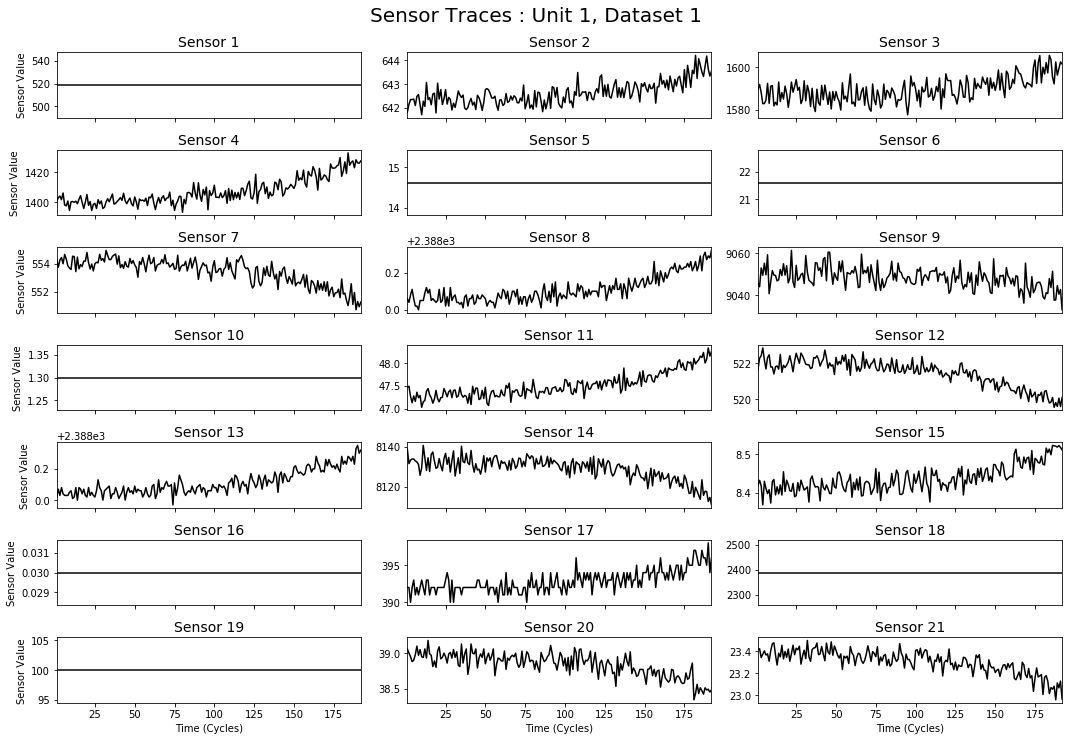

In [8]:
# extract the first unit from the first dataset
example_slice = train_df[(train_df.dataset_id == 'FD001') & (train_df.unit_id == 1)]

# plot its sensor traces over time
# note that we need 7 x 3 = 21 plots to see all sensor channels
fig, axes = plt.subplots(7, 3, figsize=(15, 10), sharex=True)
for index, ax in enumerate(axes.ravel()):
    # plot the channel corresponding to this position
    sensor_col = sensor_columns[index]
    example_slice.plot(x='cycle', y=sensor_col, ax=ax, color='black');
    # label formatting
    if index % 3 == 0:
        ax.set_ylabel("Sensor Value", size=10);
    else:
        ax.set_ylabel("");
    ax.set_xlabel("Time (Cycles)");
    ax.set_title(sensor_col.title(), size=14);
    ax.legend_.remove();
# plot formatting
fig.suptitle("Sensor Traces : Unit 1, Dataset 1", size=20, y=1.025)
fig.tight_layout();

### Visualize Multiple Engines' Sensor Readings
In the training set, all engines start with different levels of wear, and each engine’s measurements are recorded until it fails. Below we visualize the sensor readings over the lifetime of 10 randomly selected engines from the training set.

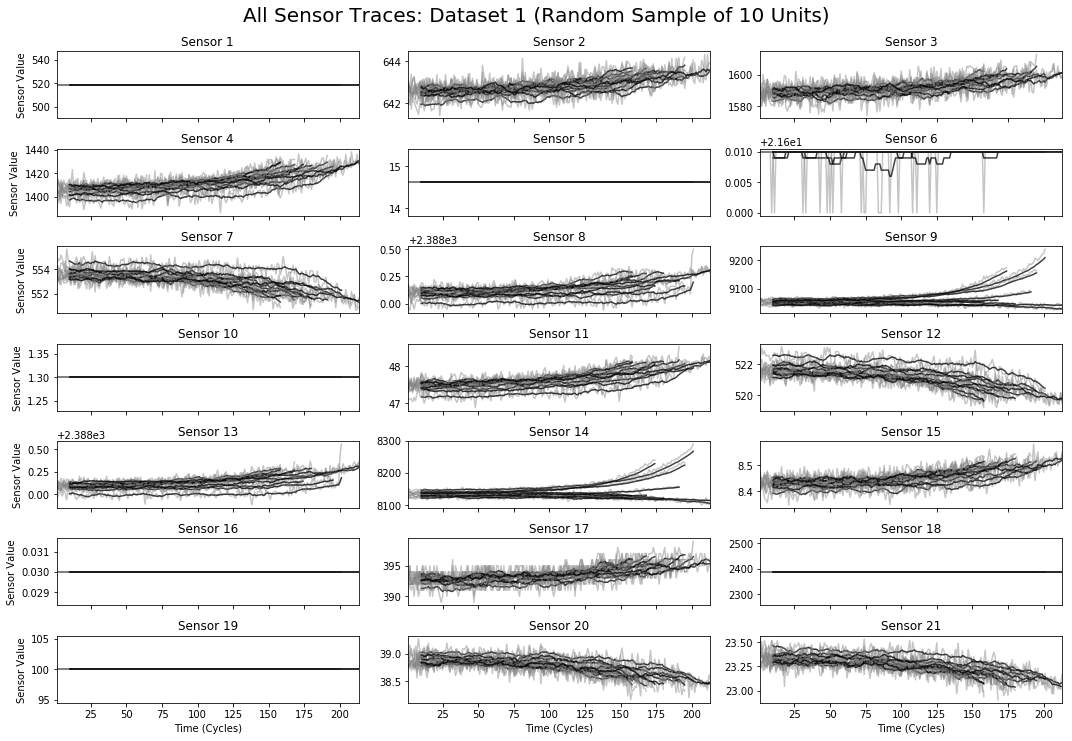

In [9]:
# randomly select 10 units from dataset 1 to plot
all_units = train_df[train_df['dataset_id'] == 'FD001']['unit_id'].unique()
units_to_plot = np.random.choice(all_units, size=10, replace=False)
# get the data for these units
plot_data = train_df[(train_df['dataset_id'] == 'FD001') & 
                     (train_df['unit_id'].isin(units_to_plot))].copy()

# plot their sensor traces (overlaid)
fig, axes = plt.subplots(7, 3, figsize=(15, 10), sharex=True)
for index, ax in enumerate(axes.ravel()):
    sensor_col = sensor_columns[index]
    for unit_id, group in plot_data.groupby('unit_id'):
        # plot the raw sensor trace
        (group
             .plot(x='cycle', y=sensor_col, alpha=0.45, ax=ax, color='gray', legend=False));
        # overlay the 10-cycle rolling mean sensor trace for visual clarity
        (group
             .rolling(window=10, on='cycle')
             .mean()
             .plot(x='cycle', y=sensor_col, alpha=.75, ax=ax, color='black', legend=False));
    # label formatting
    if index % 3 == 0:
        ax.set_ylabel("Sensor Value", size=10);
    else:
        ax.set_ylabel("");
    ax.set_title(sensor_col.title());
    ax.set_xlabel("Time (Cycles)");
# plot formatting
fig.suptitle("All Sensor Traces: Dataset 1 (Random Sample of 10 Units)", size=20, y=1.025);
fig.tight_layout();

### Normalize Sensor Traces To End At The Same Time
The engines in the training set may start with different levels of wear, but we know that they all fail at the last cycle. In order to observe common patterns in engine failure, we must first normalize the sensor channels so that they all fail at time t=0. 

In [34]:
def cycles_until_failure(r, lifetimes):
    """Compute the number of cycles remaining before failure.
    
    Parameters
    ----------
        r : pandas.Series
            single row in the training data set
        lifetimes : pandas.Series
            series of total lifetimes (cycle number when failure occurs) of 
            all engines in the training set, indexed by dataset_id and unit_id
    
    Returns
    -------
        int
            the number of cycles remaining before failure corresponding to this row
    """
    return r['cycle'] - lifetimes.ix[(r['dataset_id'], r['unit_id'])]

### Visualize The Failure Modes of Sensors, Using Normalized Traces Created Above
Since we know when each engine fails, we can compute a ‘time before failure’ value at each time step, defined as the difference between an engine’s elapsed life at that time and it’s total lifetime. This serves as a sort of countdown to failure for each engine, allowing us to align different engines’ data to a common end point. 

Aligning the data in this way allows us to observe some patterns. For instance, we see that some sensor readings consistently rise or fall right before a failure, while others (e.g. sensor 14) exhibit different failure behavior across different engines.

In [11]:
# generate the lifetimes series
lifetimes = train_df.groupby(['dataset_id', 'unit_id'])['cycle'].max()
# apply the above function to the data we're plotting
plot_data['ctf'] = plot_data.apply(lambda r: cycles_until_failure(r, lifetimes), axis=1)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


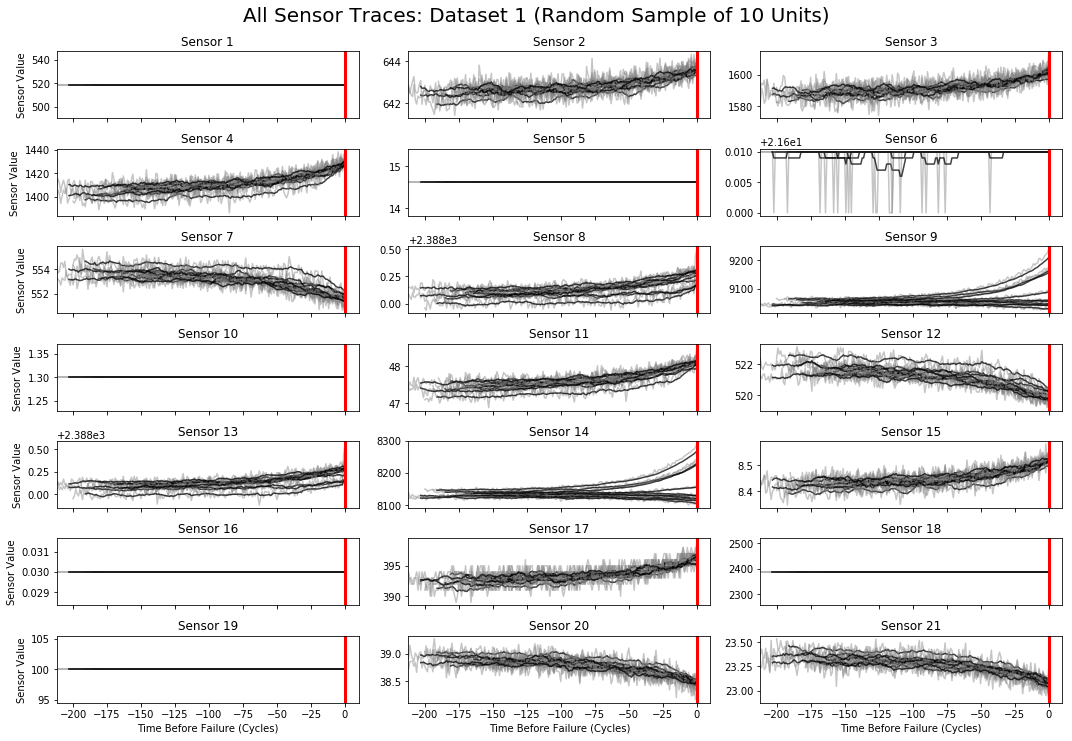

In [12]:
# plot the sensor traces (overlaid)
fig, axes = plt.subplots(7, 3, figsize=(15, 10), sharex=True)
for index, ax in enumerate(axes.ravel()):
    sensor_col = sensor_columns[index]
    # use the same subset of data as above
    for unit_id, group in plot_data.groupby('unit_id'):
        # plot the raw sensor trace, using ctf on the time axis
        (group
             .plot(x='ctf', y=sensor_col, alpha=0.45, ax=ax, color='gray', legend=False));
        # overlay the 10-cycle rolling mean sensor trace for visual clarity
        (group
             .rolling(window=10, on='ctf')
             .mean()
             .plot(x='ctf', y=sensor_col, alpha=.75, ax=ax, color='black', legend=False));
    # label formatting
    if index % 3 == 0:
        ax.set_ylabel("Sensor Value", size=10);
    else:
        ax.set_ylabel("");
    ax.set_title(sensor_col.title());
    ax.set_xlabel("Time Before Failure (Cycles)");
    # add a vertical red line to signal common time of failure
    ax.axvline(x=0, color='r', linewidth=3);
    # extend the x-axis to compensate 
    ax.set_xlim([None, 10]);
fig.suptitle("All Sensor Traces: Dataset 1 (Random Sample of 10 Units)", size=20, y=1.025);
fig.tight_layout();

Calculate correlations between each pairs of columns in the sub-sampled data and plot it.

The formula for calculating the [Pearson Correlation](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient) between two sets of data


In [13]:
pf_corr = train_df.corr(method='pearson')
pf_corr.head()

,unit_id,cycle,setting 1,setting 2,setting 3,sensor 1,sensor 2,sensor 3,sensor 4,sensor 5,...,sensor 12,sensor 13,sensor 14,sensor 15,sensor 16,sensor 17,sensor 18,sensor 19,sensor 20,sensor 21
unit_id,1.000000,-0.012765,0.312532,0.333547,-0.100764,-0.323789,-0.318260,-0.307855,-0.317691,-0.332286,...,-0.334766,-0.100701,-0.202467,0.253425,-0.286560,-0.308730,-0.238296,-0.100764,-0.332439,-0.332424
cycle,-0.012765,1.000000,-0.009588,-0.009960,0.000687,0.009526,0.012651,0.029766,0.036380,0.010034,...,0.013595,0.001481,0.098462,-0.017034,0.043034,0.029852,0.005334,0.000687,0.010540,0.010593
setting 1,0.312532,-0.009588,1.000000,0.967487,-0.163079,-0.979797,-0.925472,-0.877521,-0.909480,-0.991539,...,-0.971526,-0.163065,-0.459088,0.642981,-0.901542,-0.879403,-0.619531,-0.163079,-0.977664,-0.977674
setting 2,0.333547,-0.009960,0.967487,1.000000,-0.197923,-0.939207,-0.898218,-0.867189,-0.912110,-0.965691,...,-0.958404,-0.197861,-0.527713,0.686817,-0.932897,-0.869323,-0.623632,-0.197923,-0.959658,-0.959656
setting 3,-0.100764,0.000687,-0.163079,-0.197923,1.000000,0.264989,0.493244,0.601374,0.539436,0.230742,...,0.366734,0.999998,0.904365,-0.843670,0.359027,0.598086,0.870889,1.000000,0.344868,0.344814


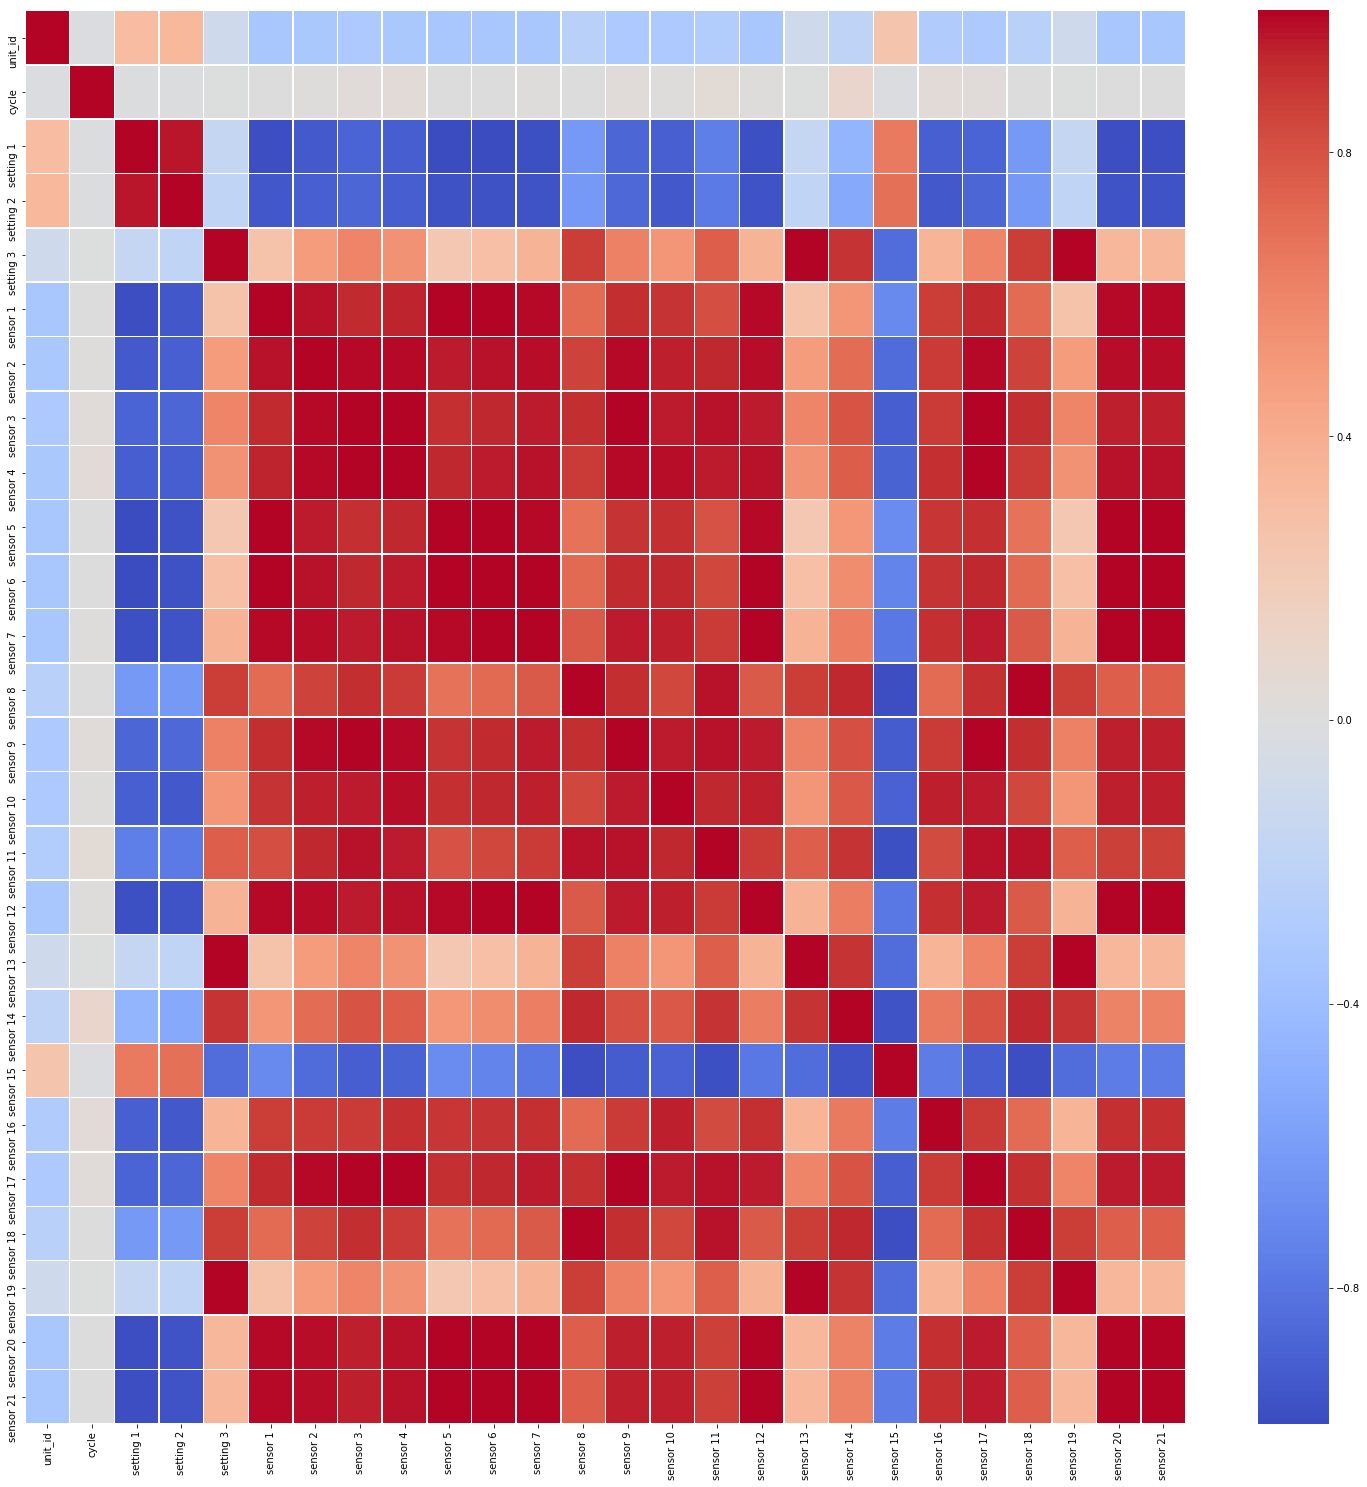

In [14]:
dims = (len(pf_corr), len(pf_corr))
fig, ax = plt.subplots(figsize=dims)
sns.heatmap(pf_corr,linewidths=.5, cmap='coolwarm')

# Model

In [54]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [118]:
train_df.ctf.describe()

count    160359.000000
mean       -122.331338
std          83.538146
min        -542.000000
25%        -172.000000
50%        -113.000000
75%         -56.000000
max           0.000000
Name: ctf, dtype: float64

In [145]:
full_train_df = train_df.copy()

train_df['ctf'] = train_df.apply(lambda r: cycles_until_failure(r, lifetimes), axis=1)
test_df['ctf'] = test_df.apply(lambda r: cycles_until_failure(r, lifetimes), axis=1)

def calc_label(ctf):
    ctf = np.abs(ctf)
    if ctf < 30: return 1
    return 0

train_df['label'] = train_df.ctf.apply(calc_label)
test_df['label'] = test_df.ctf.apply(calc_label)


0    139089
1     21270
Name: label, dtype: int64


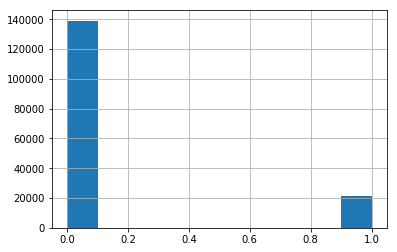

In [146]:
print train_df['label'].value_counts()
train_df['label'].hist()

In [147]:
# n_train = len(train_df[train_df.label == 1])
# n_test = len(test_df[test_df.label == 1])

# train_df_balanced = pd.concat([train_df[train_df.label == 0].sample(n=n_train), train_df[train_df.label > 0]])
# test_df_balanced = pd.concat([test_df[test_df.label == 0].sample(n=n_test), test_df[test_df.label > 0]])


# print train_df_balanced.label.value_counts()

# print test_df_balanced.label.value_counts()


In [148]:
X_train, y_train = train_df.loc[:, 'setting 1':'sensor 21'], train_df.label
X_test, y_test = test_df.loc[:, 'setting 1':'sensor 21'], test_df.label

0.920169308941
Confusion matrix, without normalization


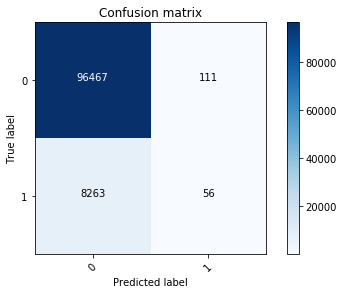

In [149]:
# LogisticRegression
model = LogisticRegression(class_weight=train_df['label'].value_counts().to_dict())
model.fit(X_train, y_train)
print model.score(X_test, y_test)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
plot_confusion_matrix(cm, classes=[0,1])

In [150]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

0.911789660333
Confusion matrix, without normalization


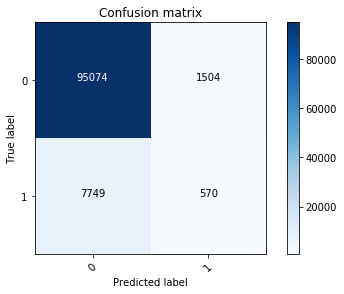

In [151]:
# RandomForestClassifier
model = RandomForestClassifier(class_weight=train_df['label'].value_counts().to_dict())
model.fit(X_train, y_train)
print model.score(X_test, y_test)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
plot_confusion_matrix(cm, classes=[0,1])

0.911827792978
Confusion matrix, without normalization


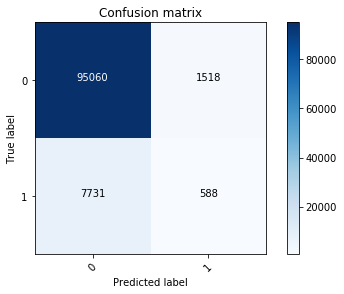

In [152]:
# GradientBoostingClassifier
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
print model.score(X_test, y_test)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
plot_confusion_matrix(cm, classes=[0,1])